<a href="https://colab.research.google.com/github/hevjinyarar/zoohackathon/blob/master/zoohackathon_Hevjin_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Get Resources and Data

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import torch
import glob
import pandas as pd
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import os
from torchsummary import summary
import torch.optim as optim

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [3]:
# get data from drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/zoohackathon/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#training data
filterNN_train_path = path + "zoohackathon_filterNN"
NN_train_path = path + "zoohackathon_NN"
#test data
test_path = path + "zoohackathon_test"

#### Clean Data

In [0]:
#TO DO
#occluded images
#noisy images --> no noisy images actually
#bad resolution images 

#### Loading images with PyTorch's DataLoader

In [0]:
# some useful parameters
validation_split = 0.3
shuffle_dataset = True
random_seed = 42

#TO DO
#transforms (Data Preprocessing)
transform_train_images = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

transform_test_images = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [0]:
#test_path will be used at the end for submission of results
def loaders(batchSize, train_path):
  #train and validation datasets and their dataloaders:
  train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train_images) #this is the whole train data
  train_data_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True, pin_memory = True) 


  #train/validation split
  dataset_size = len(train_data)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]


  sampler1 = SubsetRandomSampler(train_indices) 
  sampler2 = SubsetRandomSampler(val_indices)
  train_small_loader = torch.utils.data.DataLoader(train_data, batch_size=batchSize,
                                          sampler = sampler1)
  train_valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batchSize,
                                          sampler = sampler2)

  return train_data_loader,train_small_loader,train_valid_loader



#### Transfer Learning for Animal/Human Classification without FilterNN

In [0]:
#dataloader for NN
train_data_loader,train_small_loader,train_valid_loader = loaders(64,NN_train_path)

torch.Size([64, 3, 256, 256]) torch.Size([64]) tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])
CPU times: user 472 ms, sys: 83.2 ms, total: 555 ms
Wall time: 32.7 s


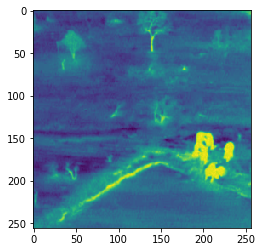

In [9]:
%%time
#first check
dataiter = iter(train_small_loader)
data_tr,data_l = dataiter.next()
print(data_tr.shape, data_l.shape, data_l)
plt.imshow(data_tr[0,0,:,:].reshape(256,256))

In [10]:
model_NN = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
model_NN.classifier[1] = torch.nn.Linear(in_features=model_NN.classifier[1].in_features, out_features=2)
print(model_NN.classifier)
model_NN.eval()

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
#first check
input_batch = data_tr.cuda()

# move the input and model to GPU for speed if available
model_NN.cuda()

with torch.no_grad():
    output = model_NN(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([0.3906, 0.6094], device='cuda:0')


In [0]:
#class weights: #animals, #humans are more or less the same

In [0]:
model = model_NN
best_acc = 0.0;history = []

In [32]:
#training
%%time
#loop over epochs/ training data
model = model_NN
best_acc = 0.0;history = []
epochs = 1
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#a short training with our images
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))
    
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    
    for i, (inputs, labels) in enumerate(train_small_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_function(outputs, labels)
        
        # Backpropagate the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
        
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


Epoch: 1/1
Batch number: 000, Training: Loss: 0.6810, Accuracy: 0.5625
Batch number: 001, Training: Loss: 0.2247, Accuracy: 0.8906
Batch number: 002, Training: Loss: 0.3629, Accuracy: 0.8750
Batch number: 003, Training: Loss: 0.0690, Accuracy: 1.0000
Batch number: 004, Training: Loss: 0.1782, Accuracy: 0.9531
Batch number: 005, Training: Loss: 0.0720, Accuracy: 0.9688
Batch number: 006, Training: Loss: 0.0178, Accuracy: 1.0000
Batch number: 007, Training: Loss: 0.0100, Accuracy: 1.0000
Batch number: 008, Training: Loss: 0.0230, Accuracy: 0.9844
Batch number: 009, Training: Loss: 0.0398, Accuracy: 0.9688
Batch number: 010, Training: Loss: 0.0035, Accuracy: 1.0000
Batch number: 011, Training: Loss: 0.0123, Accuracy: 1.0000


KeyboardInterrupt: ignored

In [33]:
#Validation
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))
    valid_loss = 0.0; valid_acc = 0.0
    ############################################
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        # Validation loop
        for j, (inputs, labels) in enumerate(train_valid_loader):
            #print(len(inputs),len(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape,labels.shape)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            #print(outputs.shape)

            # Compute loss
            loss = loss_function(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)

            print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average valid loss and valid accuracy
    avg_valid_loss = valid_loss/len(train_valid_loader)
    avg_valid_acc = valid_acc/len(train_valid_loader)

    history.append([avg_valid_loss, avg_valid_acc])
            
    epoch_end = time.time()

    print("Epoch : {:03d}, Validation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch, avg_valid_loss, avg_valid_acc*100))
    
    # Save if the model has best accuracy till now
    #model.save('model_.pt')

Epoch: 1/1
Validation Batch number: 000, Validation: Loss: 0.3686, Accuracy: 0.9219
Validation Batch number: 001, Validation: Loss: 0.2467, Accuracy: 0.9531
Validation Batch number: 002, Validation: Loss: 1.0393, Accuracy: 0.8594
Validation Batch number: 003, Validation: Loss: 0.4875, Accuracy: 0.9219
Validation Batch number: 004, Validation: Loss: 0.3417, Accuracy: 0.9531
Validation Batch number: 005, Validation: Loss: 0.3289, Accuracy: 0.9688
Validation Batch number: 006, Validation: Loss: 0.3645, Accuracy: 0.9375
Validation Batch number: 007, Validation: Loss: 0.4671, Accuracy: 0.8750
Validation Batch number: 008, Validation: Loss: 0.3682, Accuracy: 0.9062
Validation Batch number: 009, Validation: Loss: 0.2809, Accuracy: 0.9219
Validation Batch number: 010, Validation: Loss: 0.3984, Accuracy: 0.9375
Validation Batch number: 011, Validation: Loss: 0.2990, Accuracy: 0.9375
Validation Batch number: 012, Validation: Loss: 0.5618, Accuracy: 0.8906
Validation Batch number: 013, Validation

KeyboardInterrupt: ignored

In [0]:
test_folder_names = ["0000000010_0000000000",  "0000000351_0000000000",  "0000000363_0000000000",
"0000000054_0000000000",  "0000000354_0000000000",
"0000000056_0000000000",  "0000000359_0000000000"]

test_path = path + "zoohackathon_test"
def loader_test(batchSize,test_path = test_path):
  #train and validation datasets and their dataloaders:
 
  test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test_images)
  test_data_loader = DataLoader(test_data, batch_size=batchSize, shuffle=True)


  return test_data_loader


test_data_loader = loader_test(batchSize = 1)

In [43]:
len(test_data_loader)

5734

In [44]:
# TO BE COMPLETED
#predict for test data
#Validation
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))
    valid_loss = 0.0; valid_acc = 0.0
    ############################################
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            #print(len(inputs),len(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape,labels.shape)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            #print(outputs.shape)

            # Compute loss
            loss = loss_function(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)

            print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average valid loss and valid accuracy
    avg_valid_loss = valid_loss/len(train_valid_loader)
    avg_valid_acc = valid_acc/len(train_valid_loader)

    history.append([avg_valid_loss, avg_valid_acc])
            


    print("Epoch : {:03d}, Validation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch, avg_valid_loss, avg_valid_acc*100))
    
    # Save if the model has best accuracy till now
    #model.save('model_.pt')

Epoch: 1/1


RuntimeError: ignored

#### Transfer Learning for FilterNN

The idea is to create a filter NN with trasfer learning that looks at elephant and giraffe images. The images that are classified with high probability are then used for training for animal/human classification.

In [0]:
#dataloader for filterNN
train_data_loader = loaders(4,filterNN_train_path)

torch.Size([1, 3, 256, 256]) torch.Size([1])


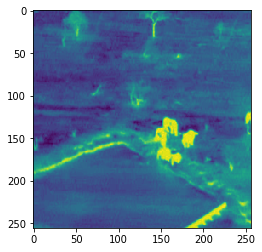

In [0]:
#first check

dataiter = iter(train_data_loader)
data_tr,data_l = dataiter.next()
print(data_tr.shape, data_l.shape)
plt.imshow(data_tr[0,0,:,:].reshape(256,256))


In [0]:
# TO BE COMPLETED
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# load a model pre-trained pre-trained on COCO
model_filterNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True )
# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # giraffe vs elephant
# get number of input features for the classifier
in_features = model_filterNN.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model_filterNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model_filterNN.to(device)
# construct an optimizer
params = [p for p in model_filterNN.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,  momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
#loss criterion
loss_function = torch.nn.NLLLoss()


In [0]:
# TO BE COMPLETED
def validate(model = model_filterNN, epochs=5):
    best_acc = 0.0;history = []
    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch+1, epochs))
        valid_loss = 0.0; valid_acc = 0.0
        ############################################
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            # Validation loop
            for j, (inputs, labels) in enumerate(train_data_loader):
                #print(len(inputs),len(labels))
                inputs = inputs.to(device)
                labels = labels.to(device)
                print(inputs.shape,labels.shape)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)[0]['scores']
                print(outputs)#.shape)

                # Compute loss
                loss = loss_function(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss/len(train_data_loader)
        avg_valid_acc = valid_acc/len(train_data_loader)

        history.append([avg_valid_loss, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Validation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch, avg_valid_loss, avg_valid_acc*100))
        
        # Save if the model has best accuracy till now
        #model.save('model_.pt')
            
    return 

In [0]:
validate()

Epoch: 1/5
torch.Size([1, 3, 256, 256]) torch.Size([1])
tensor([0.5375, 0.5047, 0.4491, 0.4385, 0.4378, 0.4326, 0.4137, 0.4136, 0.4065,
        0.4054, 0.4036, 0.4026, 0.3938, 0.3916, 0.3888, 0.3843, 0.3842, 0.3840,
        0.3830, 0.3761, 0.3740, 0.3681, 0.3667, 0.3655, 0.3646, 0.3617, 0.3579,
        0.3565, 0.3551, 0.3544, 0.3540, 0.3470, 0.3453, 0.3446, 0.3446, 0.3419,
        0.3410, 0.3391, 0.3388, 0.3379, 0.3370, 0.3351, 0.3346, 0.3340, 0.3304,
        0.3293, 0.3281, 0.3278, 0.3235, 0.3233, 0.3224, 0.3215, 0.3201, 0.3181,
        0.3162, 0.3145, 0.3145, 0.3138, 0.3128, 0.3114, 0.3095, 0.3044, 0.3032,
        0.3032, 0.3030, 0.3013, 0.2989, 0.2989, 0.2986, 0.2979, 0.2976, 0.2972,
        0.2972, 0.2971, 0.2971, 0.2961, 0.2953, 0.2938, 0.2925, 0.2922, 0.2915,
        0.2902, 0.2901, 0.2893, 0.2886, 0.2882, 0.2874, 0.2873, 0.2863, 0.2855,
        0.2849, 0.2845, 0.2845, 0.2827, 0.2824, 0.2822, 0.2804, 0.2801, 0.2777,
        0.2767], device='cuda:0')


ValueError: ignored